In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 25

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantData",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)

Found 2152 files belonging to 3 classes.


In [4]:
#this represents the 3 folders in the plantData folder
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
#represents batch size which is 32, the image size, and the channel
for image_batch, lable_batch in dataset.take(1):
    print(image_batch.shape)
    print(lable_batch.numpy())

(32, 256, 256, 3)
[0 1 1 1 0 1 1 0 1 1 1 0 1 0 0 0 1 1 1 1 0 0 0 0 1 1 2 0 1 0 0 2]


WE WILL USE !

80% DATA FOR ==> training
10% DATA FOR ==> validation
10% DATA FOR ==> test

In [7]:
#Now we split the data but we cannot do that through Sklearn in neural networks we do it using data.take !
train_size = 0.80
len(dataset)*train_size

54.400000000000006

In [8]:
#we took the training data as 54 cause len of dataset = 68 s0 68*0.75 = 51
train_ds = dataset.take(54)
len(train_ds)

54

In [9]:
#so after taking 51 as training remaining will go in test dataset
test_ds = dataset.skip(54)
len(test_ds)

14

In [10]:
#means we can take 6 samples for validation
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [11]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [12]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

# # USE OF Train_ds.cache & prefetch

WE WILL USE train_ds.cache so that it fetches the image from the disk and then it loads into cache data so that it is easily accessible fromt the cache memory when needed !

we will also use PreFetch so that when we use CPU and GPU and the GPU is busy training, then prefetch will actomatically load the next batch of images for processing 

In [16]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Now we do some PreProcessing tasks !

The first thing we do is scale and resize the image using keras Sequential where we scale it by dividing it by 255. We also scale it to 256x256 which is already done

layers.experimental.preprocessing.Rescaling 

==> is used as the Preprocessing pipeline.

# We also use DATA AUGMENTATION !

We use Data augmentation to make our model robust. It helps to even process images which might be rotated or of high contrast, etc. Data Augmentation helps in removing these inefficiencies in image.

In [17]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [18]:
#Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [19]:
#32 is the number of filters in the image
# 3 is the actual filter size 
#activation function is always 'relu' because it is extremely fast
#softmax activation function will normalize the probability of the classes
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
     resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [21]:
#metrices= the matix we will sue to track the training process

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [22]:
# the section where i am actually training my network
# history, so that we can plot a few chats late on 
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose = 1,
    validation_data=val_ds
)

Epoch 1/25
54/54 [==============================] - 186s 3s/step - loss: 0.9014 - accuracy: 0.4855 - val_loss: 0.9197 - val_accuracy: 0.4345
Epoch 2/25
54/54 [==============================] - 198s 4s/step - loss: 0.7184 - accuracy: 0.6788 - val_loss: 0.5092 - val_accuracy: 0.7976
Epoch 3/25
54/54 [==============================] - 213s 4s/step - loss: 0.4434 - accuracy: 0.8171 - val_loss: 0.3633 - val_accuracy: 0.8452
Epoch 4/25
54/54 [==============================] - 248s 5s/step - loss: 0.2930 - accuracy: 0.8831 - val_loss: 0.2292 - val_accuracy: 0.8929
Epoch 5/25
54/54 [==============================] - 211s 4s/step - loss: 0.2653 - accuracy: 0.8987 - val_loss: 0.2319 - val_accuracy: 0.9167
Epoch 6/25
54/54 [==============================] - 212s 4s/step - loss: 0.1962 - accuracy: 0.9259 - val_loss: 0.3051 - val_accuracy: 0.8869
Epoch 7/25
54/54 [==============================] - 195s 4s/step - loss: 0.1808 - accuracy: 0.9300 - val_loss: 0.1996 - val_accuracy: 0.9167
Epoch 8/25
54

In [23]:
#here we test the model, and evaluate its accuracy which is 98%
scores = model.evaluate(test_ds)

8/8 [==============================] - 6s 428ms/step - loss: 0.0478 - accuracy: 0.9805


In [24]:
scores

[0.047794315963983536, 0.98046875]

In [27]:
#history.history.keys actually tells me the parameters
history.params
history.history.keys()
    

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [30]:
#we can plot the history of accuracy of each epoc in a matplot lib chart
history.history['accuracy']

[0.48553240299224854,
 0.6788194179534912,
 0.8171296119689941,
 0.8831018805503845,
 0.8987268805503845,
 0.9259259104728699,
 0.9299768805503845,
 0.9276620149612427,
 0.9589120149612427,
 0.9548611044883728,
 0.9664351940155029,
 0.9675925970077515,
 0.9826388955116272,
 0.9525462985038757,
 0.9739583134651184,
 0.9866898059844971,
 0.9878472089767456,
 0.9861111044883728,
 0.9699074029922485,
 0.9849537014961243,
 0.9809027910232544,
 0.984375,
 0.9884259104728699,
 0.9907407164573669,
 0.9924768805503845]

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation loss')

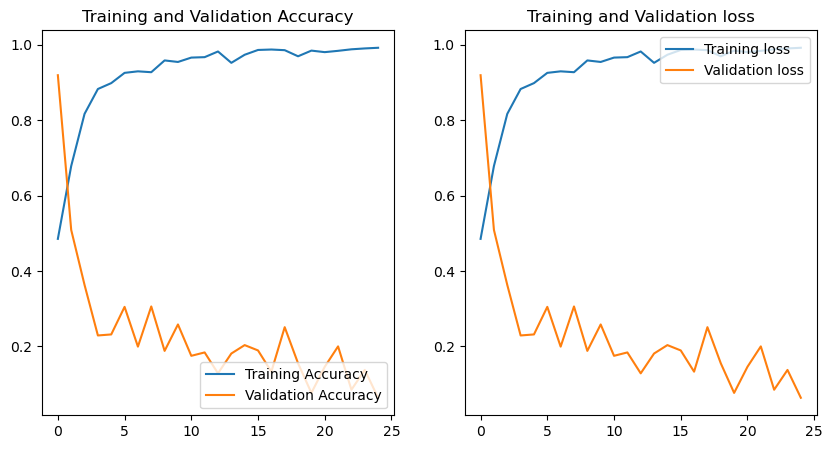

In [67]:
#here we plot training vs validation accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_loss, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), acc, label='Training loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 375ms/step
predicted label: Potato___Late_blight


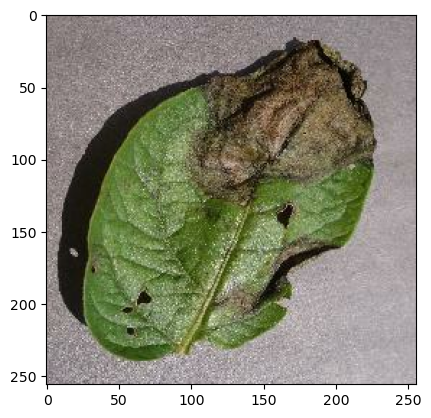

In [53]:
# now we make a prediction, so we run a for loop and take just one batch 
#predict function expects the image batch
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


In [55]:
#now am going to write a function which will take model and image as a class and give me the predicted class(late blight or early blight) and confidence
#we convert an image into an array and create a batch out of it
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 47ms/step


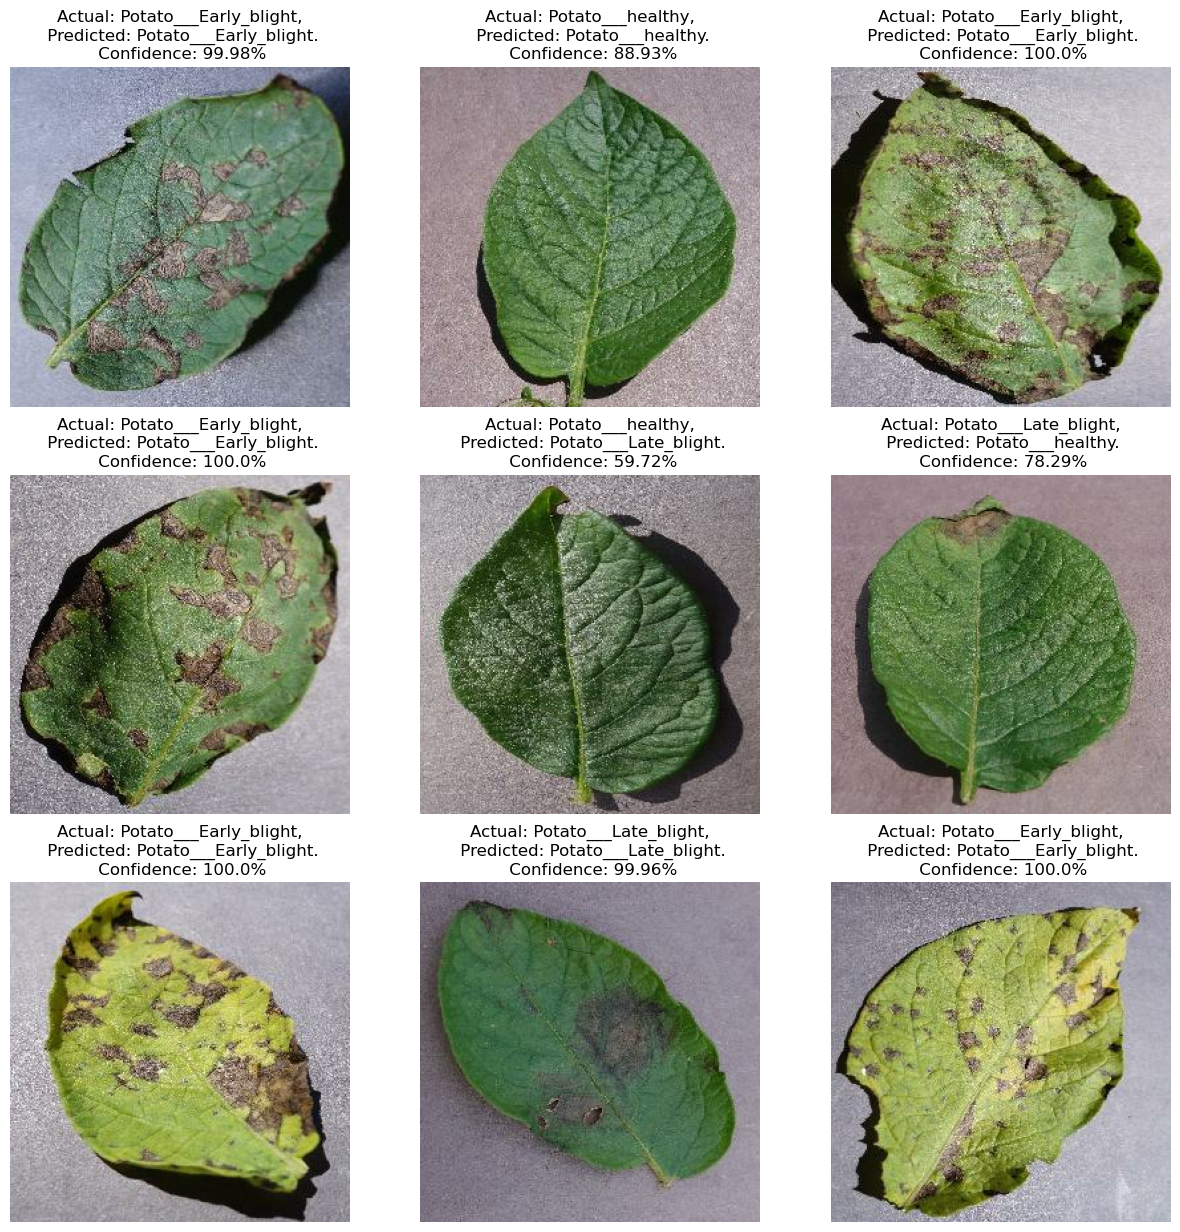

In [71]:
#now we run a for loop on the first batch and just make prediction on 9 images insted of 32
plt.figure(figsize=(15, 15)) #increases the image size according to the dimensions given
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1) #helps to show all 9 images
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off") #removes the axis on all images
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

In [66]:
model_version=1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
